In [81]:
from censai import RIMSharedUnetv3, PhysicalModelv2
from censai.models import SharedUnetModelv4
import tensorflow as tf
import json, os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import matplotlib.pylab as pylab
import h5py, glob
from matplotlib.colors import Normalize, LogNorm
from tqdm import tqdm
from scipy.stats import linregress


plt.style.use("science")
params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10, 10),
         'axes.labelsize': 25,
         'axes.titlesize':25,
         'xtick.labelsize':25,
         'ytick.labelsize':25}
pylab.rcParams.update(params)

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

np.set_printoptions(edgeitems=10)
np.core.arrayprint._line_width = 180
%matplotlib inline

In [10]:
phys = PhysicalModelv2( # use same parameter as was used during training, rescale kappa later
    pixels=128,
    kappa_pixels=128,
    src_pixels=128,
    image_fov=7.68,
    kappa_fov=7.68,
    src_fov=4,
    method="fft",
)

In [11]:
path = "/media/alexandre/Seagate/Ecole/Automne2021/Censai/models/RIMSU128hstv4_augmented_003_K3_L5_BCL2_211124140837_continue_lr6e-05_211129202839"
with open(os.path.join(path, "unet_hparams.json")) as f:
    unet_params = json.load(f)
# unet_params["kernel_l2_amp"] = args.l2_amp
unet = SharedUnetModelv4(**unet_params)
ckpt = tf.train.Checkpoint(net=unet)
checkpoint_manager = tf.train.CheckpointManager(ckpt, path, 1)
checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint).expect_partial()
with open(os.path.join(path, "rim_hparams.json")) as f:
    rim_params = json.load(f)
rim_params["source_link"] = "relu"
rim = RIMSharedUnetv3(phys, unet, **rim_params)

In [22]:
path = "/media/alexandre/Seagate/Ecole/Automne2021/Censai/results/"
pattern = "highSNR_*h5"
pattern2 = "medSNR*h5"
hf = []
for file in sorted(glob.glob(path + pattern)):
    hf.append(h5py.File(file, "r"))
for file in sorted(glob.glob(path + pattern2)):
    hf.append(h5py.File(file, "r"))
dataset = lambda b: "lenses128hst_TNG_rau_200k_control_denoised_testset_validated" if b < 300 else "lenses128hst_TNG_rau_200k_control_denoised_testset2_validated"
B = hf[0][dataset(0)]["source"].shape[0]


# Plot initial reconstruction of 200 example for reference

In [ ]:
N = 100
start = 3500


fig, axs = plt.subplots(N, 12, figsize=(48, 4 * N))
for m in range(2):
    for i in range(N):
        j = i + start + N * (m%2)
        b = j // B
        k = j % B
        lens = hf[b][dataset(b)][f"lens"][k].squeeze()
        source = hf[b][dataset(b)][f"source"][k].squeeze()
        kappa = hf[b][dataset(b)][f"kappa"][k].squeeze()
        lens_pred = hf[b][dataset(b)]["lens_pred"][k].squeeze()
        source_pred = hf[b][dataset(b)][f"source_pred"][k][-1].squeeze()
        kappa_pred = hf[b][dataset(b)][f"kappa_pred"][k][-1].squeeze()
        chi_squared = hf[b][dataset(b)][f"chi_squared"][k][-1].squeeze()
        noise_rms = hf[b][dataset(b)]["noise_rms"][k]
        intensity_cmap = "bone" # "twilight"
        a = 500
        i_min = 5e-3
#         i_norm = ImageNormalize(stretch=LogStretch(a), vmin=i_min, vmax=1)
        i_norm = Normalize(vmin=0, vmax=1)
        
        axs[i, 0+m%2].imshow(source, cmap=intensity_cmap, norm=i_norm, origin="lower")
        axs[i, 2+m%2].imshow(source_pred, cmap=intensity_cmap, norm=i_norm, origin="lower")
        axs[i, 4+m%2].imshow(kappa, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
        axs[i, 6+m%2].imshow(kappa_pred, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
        axs[i, 8+m%2].imshow(lens, cmap=intensity_cmap, norm=i_norm, origin="lower")
        axs[i, 10+m%2].imshow(lens_pred, cmap=intensity_cmap, norm=i_norm, origin="lower")
        axs[i, 10+m%2].annotate(fr"$\chi^2_\nu =$ {chi_squared:.1f}", xy=(0.3, 0.9), xycoords="axes fraction", size=25, backgroundcolor="w")

for i in range(N):            
    for j in range(12):
        k = 1 + i + N * (j%2)
        axs[i, j].axis("off")
        axs[i, j].annotate(f"{k}", xy=(0.05, 0.9), xycoords="axes fraction", size=25, backgroundcolor="w")

plt.subplots_adjust(wspace=0, hspace=-0.11)

## Question: given a specific state (i.e. having observed an image y), what is the performance of the model as a function of the noise level?

In [295]:
# pick an observation
index = 3504
b = index // B
k = index % B
lens = hf[b][dataset(b)][f"lens"][k]
source = hf[b][dataset(b)][f"source"][k]
kappa = hf[b][dataset(b)][f"kappa"][k]
lens_pred = hf[b][dataset(b)]["lens_pred"][k]
source_pred = hf[b][dataset(b)][f"source_pred"][k][-1]
kappa_pred = hf[b][dataset(b)][f"kappa_pred"][k][-1]
chi_squared = hf[b][dataset(b)][f"chi_squared"][k][-1]
noise_rms = hf[b][dataset(b)]["noise_rms"][k]
psf = hf[b][dataset(b)]["psf"][k]
wk = np.sqrt(kappa) / np.sum(np.sqrt(kappa))
ws = np.sqrt(source + 1e-4) / np.sum(np.sqrt(source + 1e-4))

In [299]:
# initialize experiment
chisq = []
source_mse = []
kappa_mse = []
obs = []
y_pred = []
s_pred= []
k_pred= []

In [300]:
# pick a range of noise levels
sigma = 10**np.linspace(-3, 0, 20)

In [355]:
kappa_mse

array([0.09048164, 0.08988716, 0.09493306, 0.10026795, 0.08680634,
       0.09980987, 0.09425493, 0.09223689, 0.09210782, 0.08668262,
       0.09622587, 0.0496662 , 0.07344368, 0.06489462, 0.0724871 ,
       0.05275546, 0.06133385, 0.06510086, 0.0312735 , 0.0422792 ],
      dtype=float32)

In [301]:
for sig in tqdm(sigma):
    y = phys.noisy_forward(source[None], kappa[None], sig, psf[None])
    s_p, k_p, ll = rim.call(y, np.array([sig]), psf[None])
    chisq.append(2*ll[-1, 0])
    obs.append(y.numpy().squeeze())
    y_pred.append(phys.forward(rim.source_link(s_p[-1]), rim.kappa_link(k_p[-1]), psf[None]).numpy().squeeze())
    s_pred.append(rim.source_link(s_p[-1]).numpy().squeeze())
    k_pred.append(rim.kappa_link(k_p[-1]).numpy().squeeze())
    source_mse.append(tf.reduce_sum(ws*tf.square(s_p[-1] - rim.source_inverse_link(source))))
    kappa_mse.append(tf.reduce_sum(wk*tf.square(k_p[-1] - rim.kappa_inverse_link(kappa))))
chisq = np.array(chisq)
source_mse = np.array(source_mse)
kappa_mse = np.array(kappa_mse)

100%|██████████| 20/20 [14:16<00:00, 42.83s/it]


In [349]:
source_mse2 = []
kappa_mse2 = []
for i in range(len(sigma)):
    source_mse2.append(np.mean(np.square(s_pred[i] - source[..., 0])))
    kappa_mse2.append(np.mean(np.square(k_pred[i] - kappa[..., 0])))

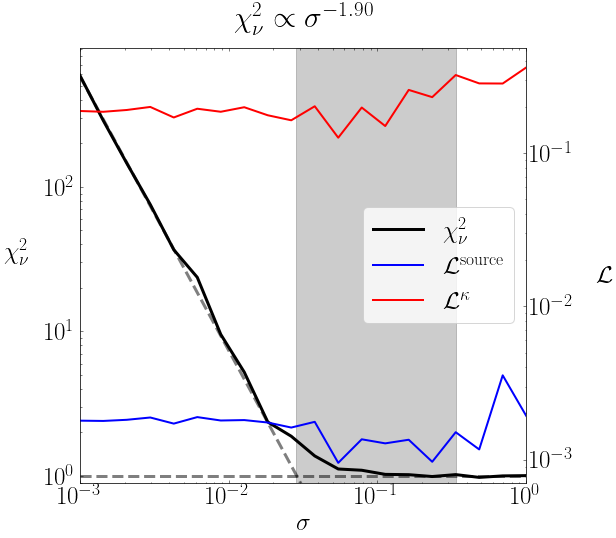

In [378]:
plt.figure(figsize=(8, 8))
ln1 = plt.loglog(sigma, chisq, "k-", lw=3, label=r"$\chi^2_\nu$")
plt.axhline(1, color="k", ls="--", lw=3, alpha=0.5)

# Make a fit of the chi^2 vs sigma relationship where the model loses precision
s = sigma < 0.005
result = linregress(np.log(sigma)[s], np.log(chisq)[s])
x = 10**np.linspace(-3, -1, 100)
y = np.exp(result.intercept) * x**(result.slope)
plt.plot(x, y, "k--", lw=3, alpha=0.5)
plt.ylim(0.9)
plt.xlim(1e-3, 1)
# Find the validity strip
# lower bound given by intercept of precision limit curve with chi = 1
# upper bound given by MSE = 2*MSE(low noise)
mse = np.array(source_mse2) + np.array(kappa_mse2)
upper = sigma[np.where(mse > 1.5 * mse[0])[0][0]]
plt.axvspan(x[np.argmin(np.abs(y - 1))], upper, color="k", alpha=0.2)
ax = plt.gca()
ax2 = ax.twinx()
ln2 = ax2.loglog(sigma, source_mse2, "b-", lw=2, label=r"$\mathcal{L}^{\mathrm{source}}$")
ln3 = ax2.loglog(sigma, kappa_mse2, "r-",  lw=2, label=r"$\mathcal{L}^{\kappa}$")
lns = ln1 + ln2 + ln3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, fontsize=25, loc=7, frameon=True)
ax2.set_ylabel(r"$\mathcal{L}$", rotation=0, labelpad=30)
ax.set_ylabel(r"$\chi^2_\nu$", rotation=0, labelpad=30)
ax.set_xlabel(r"$\sigma$")
ax.set_xticks([1e-3, 1e-2, 1e-1, 1])
ax.set_title(r"$\chi^2_\nu \propto \sigma^{%.2f}$" % result.slope, pad=20, fontsize=30);

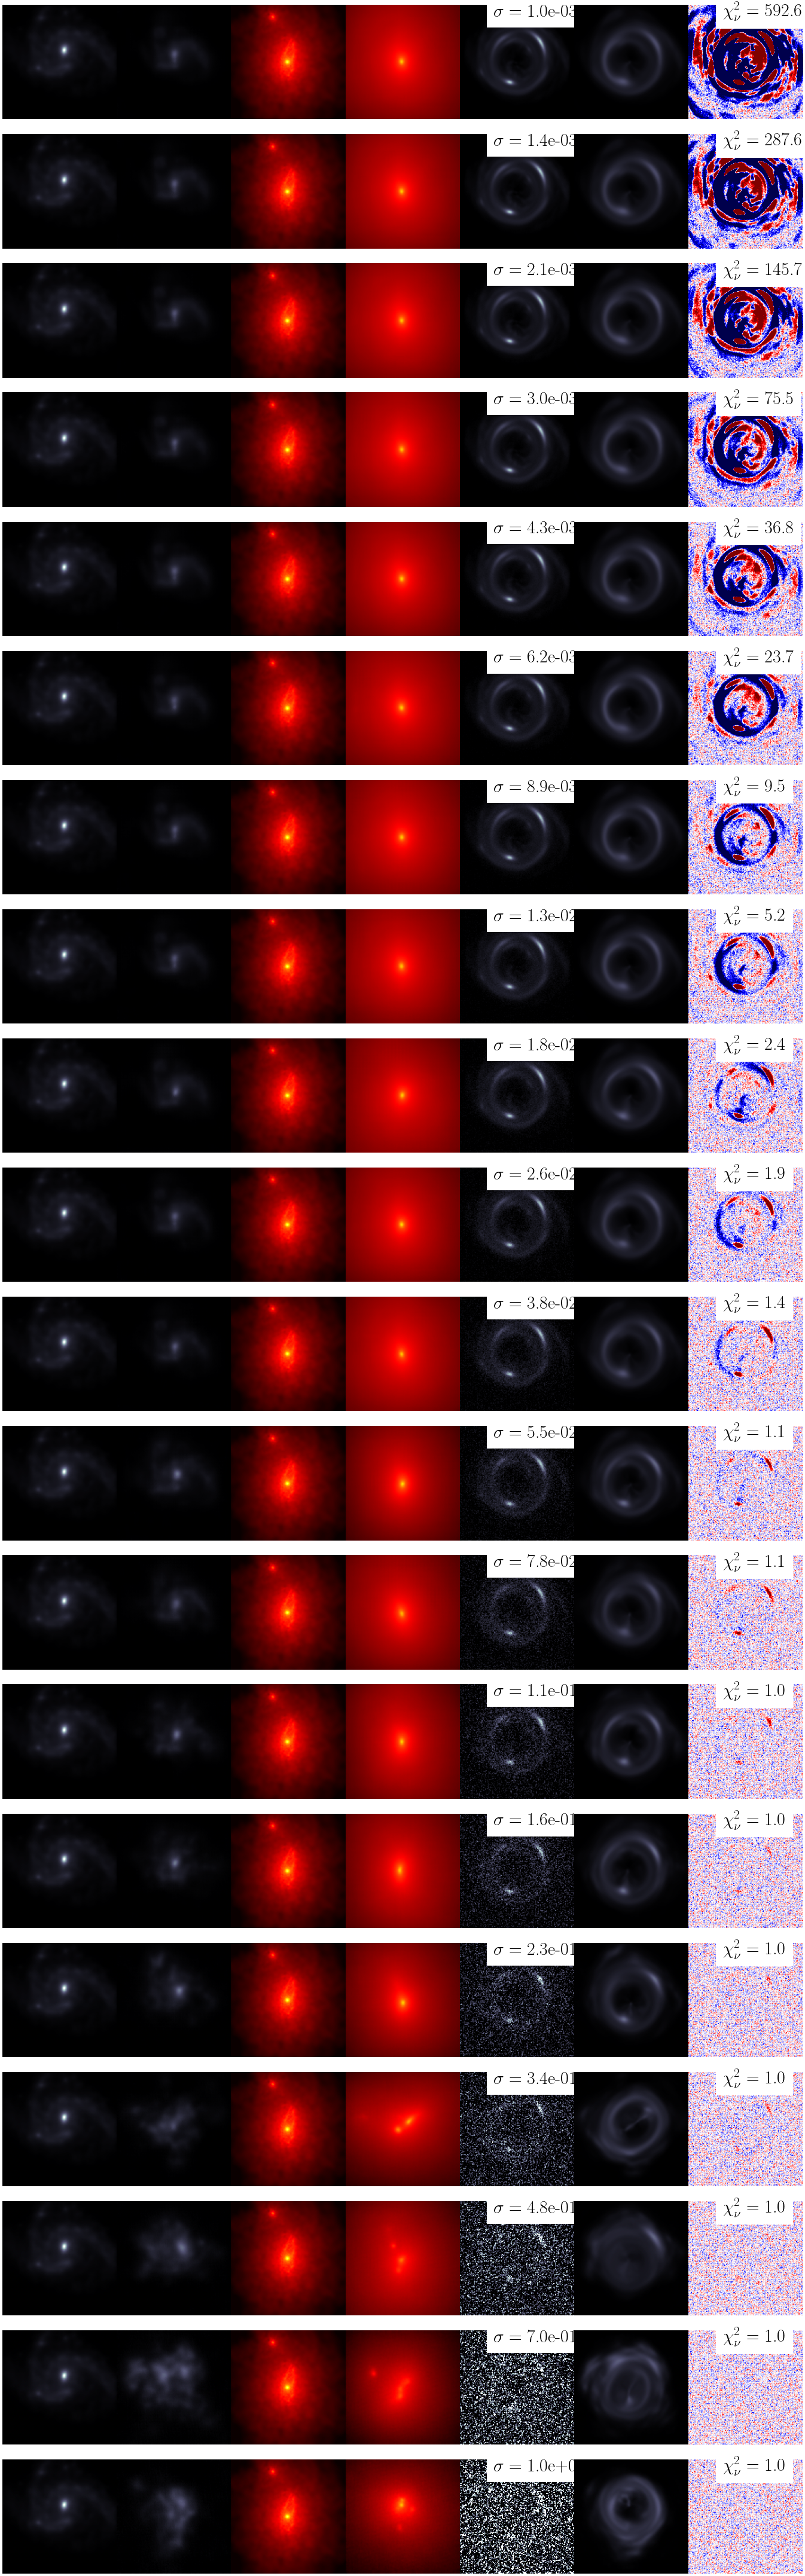

In [379]:
N = len(sigma)
fig, axs = plt.subplots(N, 7, figsize=(24, 4 * N))
for i in range(N):
    observation = obs[i]
    obs_pred = y_pred[i]
    sp = s_pred[i]
    kp = k_pred[i]
    chi_squared = chisq[i]
    intensity_cmap = "bone" # "twilight"
    a = 500
    i_min = 5e-3
#         i_norm = ImageNormalize(stretch=LogStretch(a), vmin=i_min, vmax=1)
    intensity_map = "bone"
    i_norm = Normalize(vmin=0, vmax=1)

    axs[i, 0].imshow(source.squeeze(), cmap=intensity_cmap, norm=i_norm, origin="lower")
    axs[i, 1].imshow(sp, cmap=intensity_cmap, norm=i_norm, origin="lower")
    axs[i, 2].imshow(kappa.squeeze(), cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    axs[i, 3].imshow(kp, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    axs[i, 4].imshow(observation, cmap=intensity_cmap, norm=i_norm, origin="lower")
    axs[i, 4].annotate(fr"$\sigma = $ {sigma[i]:.1e}", (0.3, 0.9), xycoords="axes fraction", backgroundcolor="w", fontsize=30)
    axs[i, 5].imshow(obs_pred, cmap=intensity_cmap, norm=i_norm, origin="lower")
    axs[i, 6].imshow((observation - obs_pred) / sigma[i], cmap="seismic", vmin=-5, vmax=5, origin="lower")
    axs[i, 6].annotate(fr"$\chi^2_\nu = $ {chi_squared:.1f}", (0.3, 0.9), xycoords="axes fraction", backgroundcolor="w", fontsize=30)

for i in range(N):            
    for j in range(7):
        axs[i, j].axis("off")

plt.subplots_adjust(wspace=0, hspace=-0.11)

In [259]:
def noise_psd(N, slope):
        X_white = np.fft.fft2(np.random.normal(size=(N, N)));
        f = np.fft.fftfreq(N)
        fx, fy = np.meshgrid(f, f)
        f = np.sqrt(fx**2 + fy**2)
        S = f**slope
        S[np.isinf(S)] = 0
        S = S / np.sqrt(np.mean(S**2))
        X_shaped = X_white * S
        return np.fft.ifft2(X_shaped).real

<ipython-input-259-2d5e3444fe22>:6: RuntimeWarning: divide by zero encountered in power
  S = f**slope


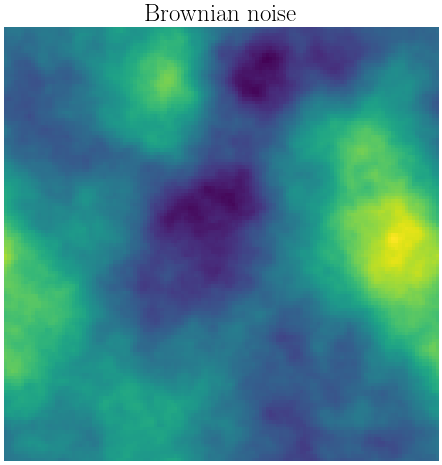

In [260]:
color = {
    "Violet" : 2,
    "Blue" : 1,
    "White" : 0,
    "Pink": -1,
    "Brownian" : -2
}

_color = "Brownian"
plt.figure(figsize=(8, 8))
plt.imshow(noise_psd(128, color[_color]))
plt.axis("off")
plt.title(_color + " noise");

In [261]:
# Select a range of color for the noise
slopes = np.arange(-2, 0.5, 0.5)
slopes

array([-2. , -1.5, -1. , -0.5,  0. ])

In [262]:
# initialize experiment
chisq_color = []
source_mse_color = []
kappa_mse_color = []
y_color = []
y_pred_color = []
s_pred_color = []
k_pred_color = []

noise_std = 0.1 # fix variance of noise where model performs well and where noise effect will be noticed

In [263]:
for color in tqdm(slopes):
    y = phys.forward(source[None], kappa[None], psf[None])
    y += noise_psd(128, color)[..., None] * noise_std
    s_p, k_p, ll = rim.call(y, np.array([noise_std]), psf[None])
    chisq_color.append(2*ll[-1, 0])
    source_mse_color.append(tf.reduce_mean(tf.square(s_p[-1] - rim.source_inverse_link(source))))
    kappa_mse_color.append(tf.reduce_mean(tf.square(k_p[-1] - rim.kappa_inverse_link(kappa))))
    y_color.append(y.numpy().squeeze())
    y_pred_color.append(phys.forward(rim.source_link(s_p[-1]), rim.kappa_link(k_p[-1]), psf[None]).numpy().squeeze())
    s_pred_color.append(rim.source_link(s_p[-1]).numpy().squeeze())
    k_pred_color.append(rim.kappa_link(k_p[-1]).numpy().squeeze())
chisq_color = np.array(chisq_color)
source_mse_color = np.array(source_mse_color)
kappa_mse_color = np.array(kappa_mse_color)

  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-259-2d5e3444fe22>:6: RuntimeWarning: divide by zero encountered in power
  S = f**slope
 40%|████      | 2/5 [01:18<01:57, 39.09s/it]<ipython-input-259-2d5e3444fe22>:6: RuntimeWarning: divide by zero encountered in reciprocal
  S = f**slope
100%|██████████| 5/5 [03:15<00:00, 39.18s/it]


Text(0.5, 1.0, '$\\sigma = 0.1$')

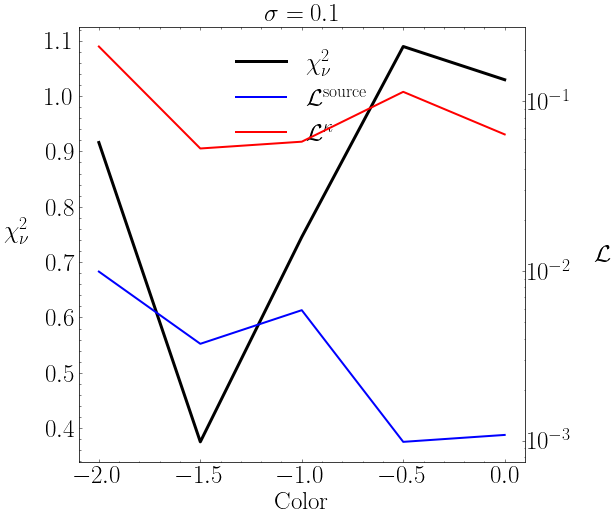

In [277]:
plt.figure(figsize=(8, 8))
ln1 = plt.plot(slopes, chisq_color, "k-", lw=3, label=r"$\chi^2_\nu$")

ax = plt.gca()
ax2 = ax.twinx()
ln2 = ax2.plot(slopes, source_mse_color, "b-", lw=2, label=r"$\mathcal{L}^{\mathrm{source}}$")
ln3 = ax2.plot(slopes, kappa_mse_color, "r-",  lw=2, label=r"$\mathcal{L}^{\kappa}$")
lns = ln1 + ln2 + ln3
labs = [l.get_label() for l in lns]
ax2.set_yscale("log")
ax.legend(lns, labs, fontsize=25, loc=9)
ax2.set_ylabel(r"$\mathcal{L}$", rotation=0, labelpad=30)
ax.set_ylabel(r"$\chi^2_\nu$", rotation=0, labelpad=30)
ax.set_xlabel(r"Color");
ax.set_title(r"$\sigma = 0.1$")

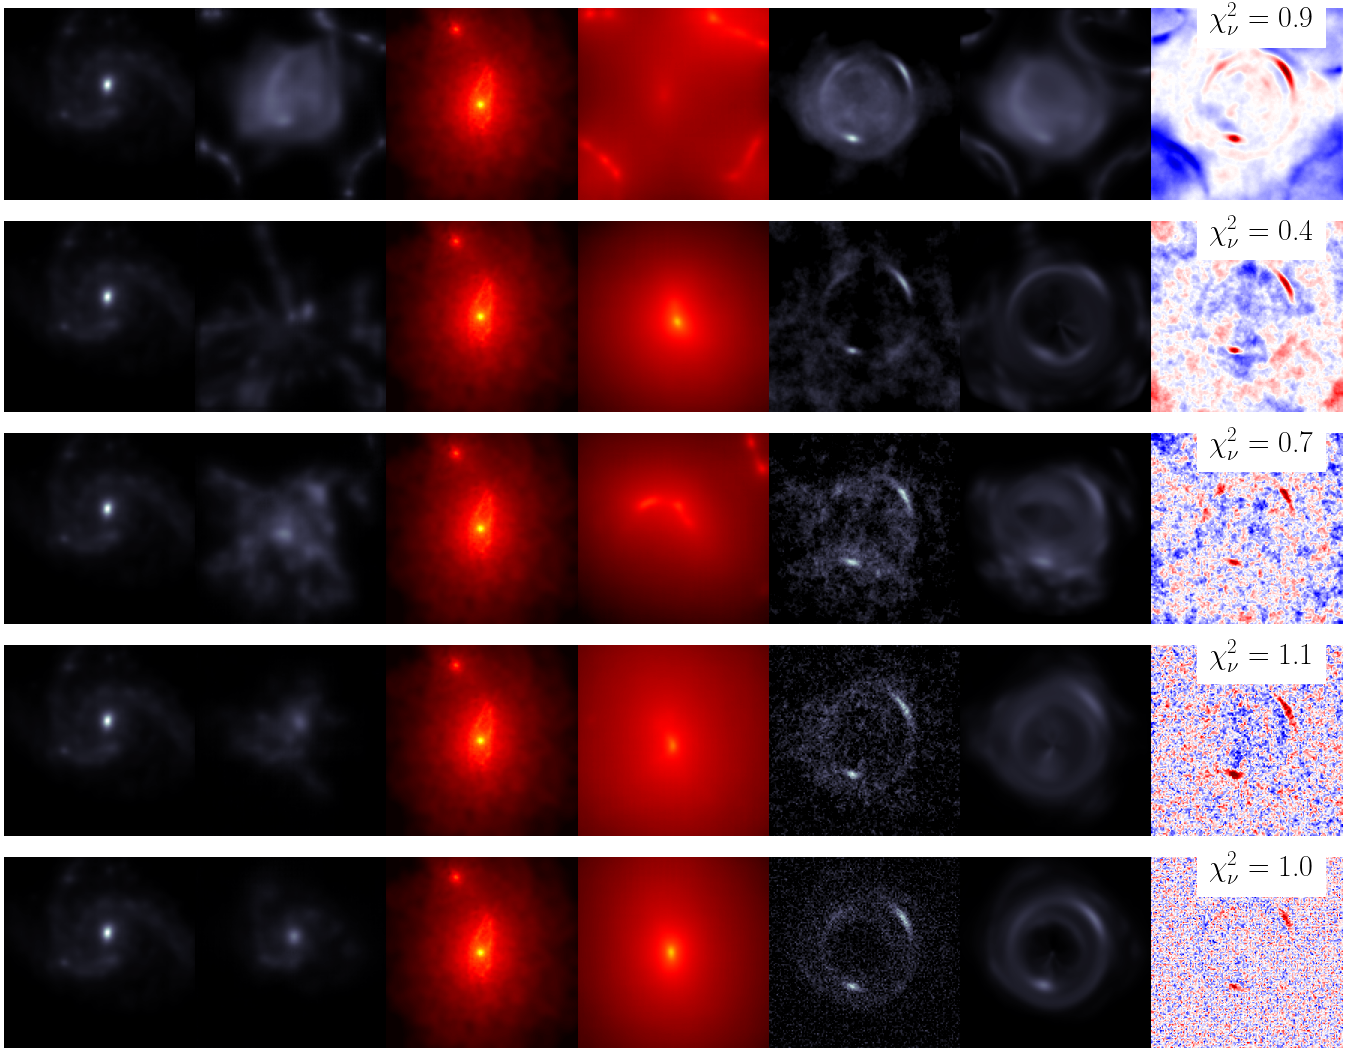

In [265]:


N = len(slopes)
fig, axs = plt.subplots(N, 7, figsize=(24, 4 * N))
for i in range(N):
    observation = y_color[i]
    obs_pred = y_pred_color[i]
    sp = s_pred_color[i]
    kp = k_pred_color[i]
    chi_squared = chisq_color[i]
    intensity_cmap = "bone" # "twilight"
    a = 500
    i_min = 5e-3
#         i_norm = ImageNormalize(stretch=LogStretch(a), vmin=i_min, vmax=1)
    intensity_map = "bone"
    i_norm = Normalize(vmin=0, vmax=1)

    axs[i, 0].imshow(source.squeeze(), cmap=intensity_cmap, norm=i_norm, origin="lower")
    axs[i, 1].imshow(sp, cmap=intensity_cmap, norm=i_norm, origin="lower")
    axs[i, 2].imshow(kappa.squeeze(), cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    axs[i, 3].imshow(kp, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    axs[i, 4].imshow(observation, cmap=intensity_cmap, norm=i_norm, origin="lower")
    axs[i, 5].imshow(obs_pred, cmap=intensity_cmap, norm=i_norm, origin="lower")
    axs[i, 6].imshow((observation - obs_pred) / noise_std, cmap="seismic", vmin=-5, vmax=5, origin="lower")
    axs[i, 6].annotate(fr"$\chi^2_\nu = $ {chi_squared:.1f}", (0.3, 0.9), xycoords="axes fraction", backgroundcolor="w", fontsize=30)

for i in range(N):            
    for j in range(7):
        axs[i, j].axis("off")

plt.subplots_adjust(wspace=0, hspace=-0.11)

In [268]:
# initialize experiment
chisq_color2 = []
source_mse_color2 = []
kappa_mse_color2 = []
y_color2 = []
y_pred_color2 = []
s_pred_color2 = []
k_pred_color2 = []

noise_std = 0.05 # fix variance to about the limit of performance of the model

In [269]:
for color in tqdm(slopes):
    y = phys.forward(source[None], kappa[None], psf[None])
    y += noise_psd(128, color)[..., None] * noise_std
    s_p, k_p, ll = rim.call(y, np.array([noise_std]), psf[None])
    chisq_color2.append(2*ll[-1, 0])
    source_mse_color2.append(tf.reduce_mean(tf.square(s_p[-1] - rim.source_inverse_link(source))))
    kappa_mse_color2.append(tf.reduce_mean(tf.square(k_p[-1] - rim.kappa_inverse_link(kappa))))
    y_color2.append(y.numpy().squeeze())
    y_pred_color2.append(phys.forward(rim.source_link(s_p[-1]), rim.kappa_link(k_p[-1]), psf[None]).numpy().squeeze())
    s_pred_color2.append(rim.source_link(s_p[-1]).numpy().squeeze())
    k_pred_color2.append(rim.kappa_link(k_p[-1]).numpy().squeeze())
chisq_color2 = np.array(chisq_color2)
source_mse_color2 = np.array(source_mse_color2)
kappa_mse_color2 = np.array(kappa_mse_color2)

  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-259-2d5e3444fe22>:6: RuntimeWarning: divide by zero encountered in power
  S = f**slope
 40%|████      | 2/5 [01:19<01:59, 39.67s/it]<ipython-input-259-2d5e3444fe22>:6: RuntimeWarning: divide by zero encountered in reciprocal
  S = f**slope
100%|██████████| 5/5 [03:18<00:00, 39.69s/it]


Text(0.5, 1.0, '$\\sigma = 0.05$')

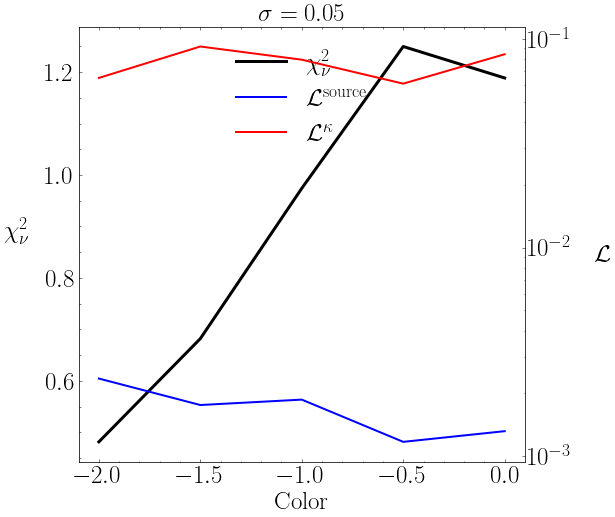

In [276]:
plt.figure(figsize=(8, 8))
ln1 = plt.plot(slopes, chisq_color2, "k-", lw=3, label=r"$\chi^2_\nu$")

ax = plt.gca()
ax2 = ax.twinx()
ln2 = ax2.plot(slopes, source_mse_color2, "b-", lw=2, label=r"$\mathcal{L}^{\mathrm{source}}$")
ln3 = ax2.plot(slopes, kappa_mse_color2, "r-",  lw=2, label=r"$\mathcal{L}^{\kappa}$")
lns = ln1 + ln2 + ln3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, fontsize=25, loc=9)
ax2.set_ylabel(r"$\mathcal{L}$", rotation=0, labelpad=30)
ax2.set_yscale("log")
ax.set_ylabel(r"$\chi^2_\nu$", rotation=0, labelpad=30)
ax.set_xlabel(r"Color");
ax.set_title(r"$\sigma = %.2f$" % noise_std)

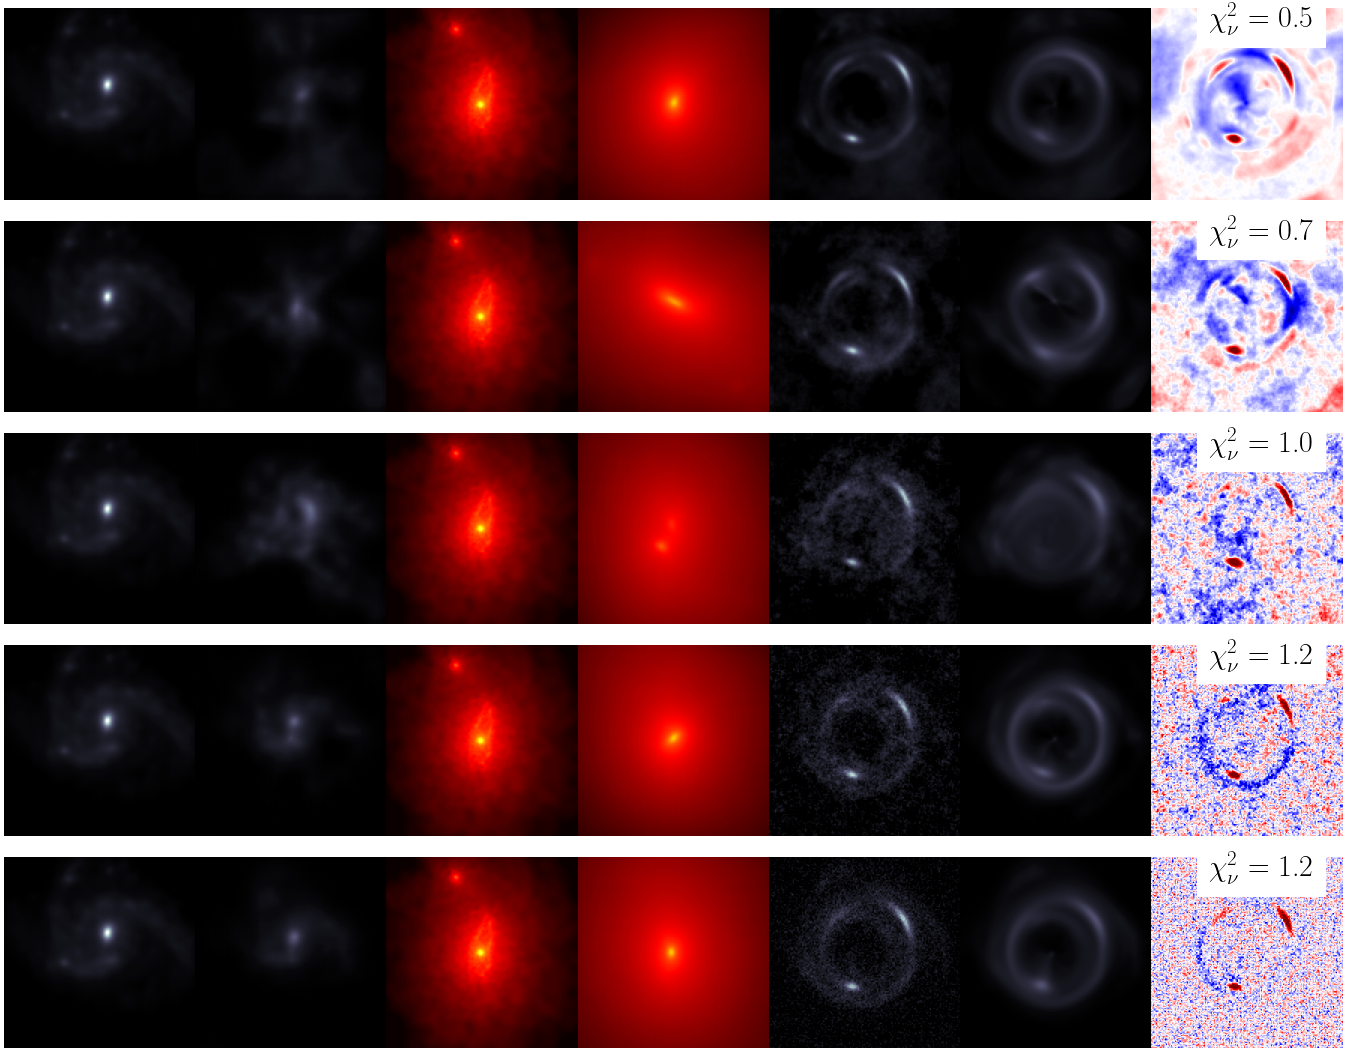

In [274]:
N = len(slopes)
fig, axs = plt.subplots(N, 7, figsize=(24, 4 * N))
for i in range(N):
    observation = y_color2[i]
    obs_pred = y_pred_color2[i]
    sp = s_pred_color2[i]
    kp = k_pred_color2[i]
    chi_squared = chisq_color2[i]
    intensity_cmap = "bone" # "twilight"
    a = 500
    i_min = 5e-3
#         i_norm = ImageNormalize(stretch=LogStretch(a), vmin=i_min, vmax=1)
    intensity_map = "bone"
    i_norm = Normalize(vmin=0, vmax=1)

    axs[i, 0].imshow(source.squeeze(), cmap=intensity_cmap, norm=i_norm, origin="lower")
    axs[i, 1].imshow(sp, cmap=intensity_cmap, norm=i_norm, origin="lower")
    axs[i, 2].imshow(kappa.squeeze(), cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    axs[i, 3].imshow(kp, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    axs[i, 4].imshow(observation, cmap=intensity_cmap, norm=i_norm, origin="lower")
    axs[i, 5].imshow(obs_pred, cmap=intensity_cmap, norm=i_norm, origin="lower")
    axs[i, 6].imshow((observation - obs_pred) / noise_std, cmap="seismic", vmin=-5, vmax=5, origin="lower")
    axs[i, 6].annotate(fr"$\chi^2_\nu = $ {chi_squared:.1f}", (0.3, 0.9), xycoords="axes fraction", backgroundcolor="w", fontsize=30)

for i in range(N):            
    for j in range(7):
        axs[i, j].axis("off")

plt.subplots_adjust(wspace=0, hspace=-0.11)